# Quaternion Kalman Filters with JAXitude

This notebook walks through increasingly complex filtering algorithms for quaternion prediction and filtering using tools available via JAXitude and its submodules.
These quaternions will represent attitudes, which means each quaternion $\beta$ discussed here has, or should have, a length of one: $|\beta| = 1$. 
As a reminder, the first element of $\beta$ is the scalar component of the unit quaternion.

We'll be tracking three types of quantities for a given observable/state with these filters:

- The true value will be denoted simply as $\mathbf{x}$.
- The prior estimate value propogated from a dynamical system model: $\hat{\mathbf{x}}$, where $\hat{\mathbf{x}} = \text{E}[\mathbf{x}]$. 
- Measurements will be denoted with the vector $\mathbf{y}$, where $\mathbf{y} = \mathbf{h}(\mathbf{x}, \boldsymbol{\epsilon})$ for some measurement model $\mathbf{h}$ and measurement noise $\boldsymbol{\eta}$. Measurement estimates from prior predictions $\hat{\mathbf{x}}$ will be denoted $\hat{\mathbf{y}} = \mathbf{h}(\hat{\mathbf{x}},\mathbf{0})$. 
- For specific physical quantities, a bar will be used to denote a relationship/measurement model between measured and true values. For example, the measured attitude rate vector $\bar{\boldsymbol{\omega}} = \boldsymbol{\omega} + \boldsymbol{\epsilon}_{\omega}$, where $\boldsymbol{\epsilon}_{\omega}$ is the attitude rate measurement error (gyroscope bias is neglected in this particular example).

Quaternion inverses will be used later in this demo, so as a reminder the inverse of $\beta$ is 

$\beta^{-1} = \begin{bmatrix} \beta_0 \\ -\boldsymbol{\beta}_{1:3} \end{bmatrix}$.

We will repeat this when directlyed use again, but we define and denote the mapping operations to and from the three-dimensional vector space to the unit quaternion space as $(.)^{\wedge}$ and $(.)^{\vee}$, respectively:

$(\mathbf{v})^{\wedge} = \exp{\begin{bmatrix} 0 \\ \mathbf{b} \end{bmatrix}}$,  $(\beta)^{\vee} = \log{\beta}\in\mathcal{R}^3$,

where $\mathbf{v}\in\mathcal{R}^3$ and $\exp$ and $\log$ denote the matrix exponential and matrix inverse exponential, respectively.

From this data set we will track state errors using in an Inertial relative Navigation (iRN) setting, where the inertial frame will simply be the body frame at $t=0$.

As always with JAXitude, quaternions $\beta$ will be represented by a column vector, not a row vector or 1D array!

```Python
b = jnp.array(
    [[b0],
     [b1],
     [b2],
     [b3]]
)
```

The same goes for attitude rate vectors $\omega$.

```Python
w = jnp.array(
    [[w0],
     [w1],
     [w2]]
)
```

## Loading Simulation Data

For these exercises, we'll make use of simulated attitude and attitude rates of a rigid body undergoing two episodes of angular acceration.

In [1]:
from pathlib import Path
import sys
import os
sys.path.append(str(Path(os.getcwd()).parent))

from numpy import genfromtxt
import jax.numpy as jnp
from jax import config
config.update('jax_enable_x64', True)  # Default to double float precision.

data_path = Path('data/') / 'attitude_acc1'


# Load observed gyroscope data.
with open(data_path / 'gyro-0.csv', 'r') as f:
    w_obs_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true gyroscope data.
with open(data_path / 'ref_gyro.csv', 'r') as f:
    w_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with quaternions).
with open(data_path / 'ref_att_quat.csv', 'r') as f:
    b_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with Euler angles).
with open(data_path / 'ref_att_euler.csv', 'r') as f:
    ea_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# load simulation time data.
with open(data_path / 'time.csv', 'r') as f:
    t_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Remember: all vector data must be transformed to column vectors to utilize
# JAXitude calculations!  Also, convert deg/s to rad/s
n_steps = jnp.shape(t_data)[0]
w_obs_data = w_obs_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
w_true_data = w_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
b_true_data = b_true_data.reshape((n_steps, 4, 1))
ea_true_data = ea_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.

## Adding Noise to 'True' Quaternion Data

We now want to simulate quaternion measurements from the simulated quaternion time series.
To do so, we'll make use of `jaxitude.operations.error.QuatNoise`, `jax.random`, and `jax.vmap()`.

In [2]:
from jax import vmap
from jax.random import PRNGKey, split

from jaxitude.operations.error import QuatNoise

# We need a random key to generate noise.
key = PRNGKey(1)

# Quaternion rotation angle error standard deviation will be set to 8 degrees.
sigma_dtheta = 8. * jnp.pi / 180.  # Convert to radians for JAXitude!


# For this helper function, we'll define it for a single key, b argument pair
# and then vectorize with vmap.
@vmap
def addnoise_sample(key: int, b: jnp.ndarray) -> jnp.ndarray:
    """ This helper function takes the quaternion set b, makes sure it is
        normalized, and adds noise.
    """
    # We get the rotation matrix R(b) by calling the instantiated Quaternion
    # object.  Note that we also normalized the quaternion set.
    return QuatNoise.addnoise(key, b / jnp.linalg.norm(b), sigma_dtheta)

# Simulate measured attitude time series.
key, subkey = split(key)
b_obs_data = addnoise_sample(split(subkey, n_steps),b_true_data)


## Filter 1: Additive Extended Kalman Filter

The Additive Extended Kalman Filter (AEKF) estimates the object of interest's attitude with a unit quaternion $\hat{\beta}$, which is then estimated using an additive error model (more on that later). 
Important is that AEKF, although ostensibly estimating a ]unit quaternion at any given time step, does not explicitly or implicitly respect the unit-length condition $|\hat{\beta}| = 1$. 
Regardless, it's a good place to start implementing a quaternion-based filtering algorithm.

### Sensor Models

Before implementing the AEKF algorithm, we first should define some sensor models. 
We will have two pieces of data at any given time step $k$: a gyroscope rate vector sensor measurement $\bar{\boldsymbol{\omega}}$ and quaternion sensor measurements $\bar{\beta}$.
We'll use the Farrenkopf gyroscope sensor error model, which relates the measured attitude rate $\bar{\boldsymbol{\omega}}$ to a true rate $\boldsymbol{\omega}$ via the following equation:

$\bar{\boldsymbol{\omega}} = \boldsymbol{\omega} + \mathbf{b} + \boldsymbol{\nu}_{\boldsymbol{\omega}}$,

where $\mathbf{b}$ is the gyroscope bias at the time of sensor measurement and $\boldsymbol{\nu}_{\boldsymbol{\omega}} \sim \mathcal{N}(0, [M_{\boldsymbol{\omega}}])$ is the attitude rate uncorrelated measurment error vector with covariance $[R_{\boldsymbol{\omega}}]$. 

As we will find out later, this quaternion sensor model we'll use here is unsatisfactory.
For now, we will assume a simple additive model akin to that used for $\bar{\omega}$:

$\bar{\beta} = \beta + \nu_{\beta}$,

where $\nu_{\beta} \sim \mathcal{N}(0, [R_{\beta}])$ is the quaternion sensor measurement error with covariance $[R_{\beta}]$.
The astute reader might have already spotted a problem with this formulation --- namely, that the unit constraint $|\beta|=1$ results in a singular covariance matrix $[Q_{\beta}]$.
Quaternions are not a minimal attitude representation!

Let's instantiate these sensor measurement covariance matrices.

In [3]:
sigmaR_b = 1e-3
sigmaR_w = 1e-3

R_b = jnp.eye(4) * sigmaR_b**2.
R_w = jnp.eye(3) * sigmaR_w**2.

### State Model

The full seven-dimensional state vector that the AEKF will track is the combined set of quaternion and gyroscope bias parameters: 

$\mathbf{x} = \begin{bmatrix} \beta \\ \mathbf{b} \end{bmatrix}$

subject to the constraint $|\beta| = 1$. 
We also want to consider the state estimate's error $\delta\mathbf{x}$ when tracking the state covariance estimate (more on that later):

$\delta\mathbf{x} = \mathbf{x} - \hat{\mathbf{x}} = \begin{bmatrix} \beta - \hat{\beta} \\ \mathbf{b} - \hat{\mathbf{b}} \end{bmatrix}$,

where $\hat{\mathbf{x}} = \text{E}[\mathbf{x}]$ is the algorithm's estimated state vector. 
Note that this definition implies $\text{E}[\delta\mathbf{x}] = \mathbf{0}$.

### Dynamics Model Components

The time derivative of $\beta$ can be found given an attitude rate $\omega$ via the following equation:

$\dot{\beta} = \frac{1}{2}\beta \otimes \boldsymbol{\omega}^{\wedge} + \eta_{\dot{\beta}}$,

where $\boldsymbol{\omega}^{\wedge} = [0, \boldsymbol{\omega}]^T$, with $(.)^{\wedge}$ denoting an operation mapping a three-dimensional vector to a quaternion. 
The $\otimes$ operator denotes quaternion multiplication.
Plugging in the sensor model for $\boldsymbol{\omega}$ after solving for $\bar{\boldsymbol{\omega}}$ yields

$ \dot{\beta} = \frac{1}{2}\beta \otimes (\bar{\boldsymbol{\omega}} - \mathbf{b} - \boldsymbol{\nu}_{\boldsymbol{\omega}})^{\wedge}$,


The bias $\mathbf{b}$ is modeled a Gaussian random walk:

$\dot{\mathbf{b}} = \boldsymbol{\eta}_{\mathbf{b}}$,

where $\boldsymbol{\eta}_{\mathbf{b}} \sim \mathcal{N}(0, [Q_{\mathbf{b}}])$ is the attitude bias rate error with covariance $[Q_{\mathbf{b}}]$. 

Let's instantiate that covariance matrix $[Q_{\mathbf{b}}]$.

In [4]:
sigmaQ_bias = 1e-3

Q_bias = jnp.eye(3) * sigmaQ_bias**2.

### Full Dynamical Model

Combining $\dot{\beta}$ with this bias rate model yields the full dynamical model:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x} | \bar{\boldsymbol{\omega}} - \mathbf{b}) + \mathbf{g}(\mathbf{x}, \boldsymbol{\eta}) + \mathbf{e}_{\mathbf{x}}$

where

$\mathbf{f}(\mathbf{x} | \bar{\boldsymbol{\omega}} - \mathbf{b}) = \begin{bmatrix}\frac{1}{2}\beta \otimes (\bar{\boldsymbol{\omega}} - \mathbf{b})^{\wedge} \\ \mathbf{0} \end{bmatrix}$,

$\mathbf{g}(\mathbf{x}, \mathbf{\eta}) = \begin{bmatrix}-\frac{1}{2}\beta \otimes \boldsymbol{\nu}_{\boldsymbol{\omega}}^{\wedge} \\ \mathbf{\boldsymbol{\eta}}_{\mathbf{b}} \end{bmatrix} = \begin{bmatrix}-\frac{1}{2}\beta \otimes \boldsymbol{\eta}_{\boldsymbol{\omega}}^{\wedge} \\ \mathbf{\boldsymbol{\eta}}_{\mathbf{b}} \end{bmatrix}$,

and $\mathbf{e}_{\mathbf{x}} \sim \mathcal{N}(0, [Q]^{(a)})$ is an additive process error arising from unmodeled physical processes with additive process noise covariance $[Q]^{(a)}$. 
This $[Q]^{(a)}$ is difficult to estimate in general, so it will just be given.

Quick note: we do not necessarily need a gyroscope bias component for the additive process error because of the structure of $\mathbf{g}$ --- it's $\mathbf{b}$ components are an identity function. 
This means the $\mathbf{b}$ elements of both $[Q]^{(a)}$ and $[Q]^{(i)}$ are degenerate, so we could just group them together into either $[Q]^{(a)}$ or $[Q]^{(i)}$. 
We will keep them separate for clarity, and because the $[Q]^{(a)}$ provides an opportunity to account for additional gyroscope bias uncertainty in an explicit fashion, ostensibly easing interpretability.

Let's also implement the $\mathbf{f}$ and $\mathbf{g}$ functions, making use of `jaxitude.quaterions.evolve_quat()` in to simplify things.

In [5]:
from jax.scipy.linalg import block_diag
from jaxitude.quaternions import evolve_quat

# This is a tuned approximation...  
sigmaQ_b = 1e-2
sigmaQ_bias_additional = 1e-4

q_gain = 10.
Q_a = q_gain * block_diag(
    jnp.eye(4) * sigmaQ_b**2.,
    jnp.eye(3) * sigmaQ_bias_additional**2.
)


class AEKF:
    @staticmethod
    def f(
        x_est: jnp.ndarray,
        w: jnp.ndarray,
    ) -> jnp.ndarray:
        """ Dynamical system equations relating current state and measured rates
            w to dx/dt.

        Args:
            x_est (jnp.ndarray): 7x1 matrix, state vector estimate.
            w (jnp.ndarray): 3x1 matrix, measured rate vector.

        Returns:
            jnp.ndarray: 7x1 matrix, dx/dt.
        """
        return jnp.vstack(
            [
                evolve_quat(x_est[:4, :], w - x_est[4:, :]),
                jnp.zeros((3, 1))
            ]
        )


    @staticmethod
    def g(
        x_est: jnp.ndarray,
        eta: jnp.ndarray,
    ) -> jnp.ndarray:
        """ System noise equations calculated from state and noise vector.

        Args:
            x_est (jnp.ndarray): 7x1 matrix, state vector estimate.
            eta (jnp.ndarray): 7x1 matrix, noise vector.

        Returns:
            jnp.ndarray: 7x1 matrix, noise contribution to dx/dt.
        """
        return jnp.vstack(
            [
                evolve_quat(x_est[:4, :], eta[:4, :]),
                eta[4:, :]
            ]
    )

Note that we are now treating $\nu_{\omega_4} \rightarrow \eta_{\omega_4}$ (and $[R_{\boldsymbol{\omega}}] \rightarrow [Q_{\boldsymbol{\omega}}]$ ) as part of the dynamics process noise *within* the dynamics (the function $\mathbf{g}$, specifically): $\boldsymbol{\eta} = [\eta_{\omega_4}, \boldsymbol{\eta}_{\mathbf{b}}]^T$. 
This internal noise covariance $[Q]^{(i)}$ will be defined as

$[Q]^{(i)}= \begin{bmatrix}[R_{\boldsymbol{\omega}}] & 0 \\ 0 & [Q_{\mathbf{b}}]\end{bmatrix} = \begin{bmatrix} [Q_{\boldsymbol{\omega}}] & 0 \\ 0 & [Q_{\mathbf{b}}]\end{bmatrix}$.

Let's code up $[Q]^{(i)}$ real quick.

In [6]:
Q_i = block_diag(
    jnp.eye(4) * sigmaR_w**2,
    jnp.eye(3) * sigmaQ_bias**2
)

Not only do we need to track the state vector estimate (or in this case, the state error vector), but we also need to track the state covariance estimate $[\hat{P}] = \text{E}[\delta\mathbf{x}\delta\mathbf{x}^.T]$, where $\delta\mathbf{x} = \mathbf{x} - \hat{\mathbf{x}}$. 
Reformulating the dynamics in terms of the state error vector yields

$\delta\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x} | (\bar{\boldsymbol{\omega}} - \mathbf{b})^{\wedge}) + \mathbf{g}(\mathbf{x}, \boldsymbol{\eta}) + \mathbf{e}_{\mathbf{x}} -  \mathbf{f}(\hat{\mathbf{x}} | (\bar{\boldsymbol{\omega}} - \mathbf{b})^{\wedge}) + \mathbf{g}(\hat{\mathbf{x}}, \boldsymbol{\eta})$,

where, as a reminder, $\hat{\mathbf{x}}$ is the current state estimate.

To propogate $[\hat{P}]$ we can linearize the error dynamics above around the current state estimate $\hat{\mathbf{x}}$ and $\boldsymbol{\eta} = 0$, the former being analogous with linearizing around $\delta\mathbf{x} = \text{E}[\delta\mathbf{x}] = 0$:

$\delta\dot{\mathbf{x}} = [F]\delta\mathbf{x} + [G]\boldsymbol{\eta}$,

where

$[F] = \frac{d\mathbf{f}}{d(\delta{\mathbf{x}})} \Big\rvert_{\delta{\mathbf{x}} = 0}$

and

$[F] = \frac{d\mathbf{g}}{d(\delta{\mathbf{x}})} \Big\rvert_{\delta{\mathbf{x}},\boldsymbol{\eta}=0}$.

With $[F]$ and $[G]$, we can propogate $[\hat{P}]$ using the Ricatti differential equation:

$[\dot{\hat{P}}] = [F][\hat{P}] + [\hat{P}][F]^T + [G][Q]^{(i)}[G]^T + [Q]^{(a)}$,

where $[Q]^{(i)}$ and $[Q]^{(a)}$ are the process noise covariances mentioned earlier. 

We can use `jaxitude.operations.linearize.tangent()` to calculate these jacobian matrices for us.

In [7]:
from jaxitude.operations.linearization import tangent


def tangent_f(
    x_est: jnp.ndarray,
    w_obs: jnp.ndarray
) -> jnp.ndarray:
    """ Gets the linearized kinematics equation matrix at x=x_ref:
        F = Jac(f(x, w=w_obs))(x_est).

    Args:
        x_est (jnp.ndarray): 7x1 matrix, state vector estimate to linearize
            at.
        w_obs (jnp.ndarray): 3x1 matrix, measured attitude rate vector.

    Returns:
        jnp.ndarray: 7x7 matrix, linearized kinematics system matrix F.
    """
    # Linearize f(x, w=w_obs) about x_est.
    return tangent(
        lambda x: AEKF.f(x, w_obs),
        7, 0, x_est
    )


def tangent_g(
    x_est: jnp.ndarray,
) -> jnp.ndarray:
    """ Gets the linearized kinematics equation matrix at eta=0:
        G = Jac(g(x=x_est, eta))(eta=0).

    Args:
        x_est (jnp.ndarray): 7x1 matrix, state vector to linearize at.

    Returns:
        jnp.ndarray: 7x7 matrix, linearized noise system matrix G.
    """
    # Linearize g(x=x_est, eta) about eta=0.
    return tangent(
        lambda eta: AEKF.g(x_est, eta),
        7, 0, jnp.zeros((7, 1))
    )

# Store new functions as static methods for safe keeping.
AEKF.tangent_f = staticmethod(tangent_f)
AEKF.tangent_g = staticmethod(tangent_g)

To propogate the state err estimate from $\mathbf{x}_k$ to $\mathbf{x}_{k + 1}$ along a time step $\Delta t = t_{k + 1} - t_k$, we need to numerically solve $\delta\dot{\mathbf{x}}$ along the time step $\Delta t=t_{k+1} - t_k$. 
This numerical solution for $\dot{\mathbf{x}}$ approximates the state transition equation.
Although we will use higher-order ODE integrators, an example of this state transition equation for $\mathbf{x}$ using Euler's method is:

$\mathbf{x}_{k + 1} = \mathbf{x}_{k} + \dot{\mathbf{x}}_k \Delta t$.

We can similarly propogate the prior state covariance estimate $[\hat{P}]_k$ along time step $\Delta t$:

$[\hat{P}]_{k + 1} = [\hat{P}]_k + [\dot{\hat{P}}]\Delta t$.


To calculate the state vector and state covariance transition functions, we need an ODE solver/integrator (these terms interchangeably in this context). 
This algorithm will use JAXitude's Runge-Kutta 4 integrator `jaxitude.operations.integrator.autonomous_rk4()` to numerically integrate along the each time step $\Delta t$. 
It will similarly make use of `jaxitude.operations.evolution.evolve_P_ricatti()` to integrate $[\dot{\hat{P}}]$.

It is work reminding the reader of JAXitude's numerical ODE integrator API.
Each autonomous (time-independent) integrator, such as `autunomous_rk4()`, expects for its first argument a Python function `func`. 
This callable function's first argument be the (mathematical) function you are trying to solve for using the ODE integrator. 
In the first function below (`pred_x()`), we are trying to solve the state vector $\mathbf{x}$ using `AEKF.f()` (which is our `func` in this example), whose first argument is  `x_prior`, which indeed corresponds to the vector we are trying to solve.
Naturally, `autunomous_rk4()` expects as it's second argument the value of said vector during this integration time step. 
The ODE integration time step $dt$ must be `autunomous_rk4()`'s third argument, followed lastly by any other arguments to pass onto `func`.

In [8]:
import importlib
from jaxitude.operations import evolution
importlib.reload(evolution)

from jaxitude.operations.evolution import evolve_P_ricatti
from jaxitude.operations.integrator import autonomous_rk4


# We can calculate dt directly from the data right now.
dt = t_data[1] - t_data[0]


def pred_x(
    x_prior: jnp.ndarray,
    w_obs: jnp.ndarray,
    dt: float
) -> jnp.ndarray:
    """ Predicts new state vector x_post from x_prior and w_obs along time
        interval dt.

    Args:
        x_prior (jnp.ndarray): 7x1 matrix, prior state vector estimate.
        w_obs (jnp.ndarray): 3x1 matrix, current attitude rate vector
            measurement
        dt (float): time step to integrate.

    Returns:
        jnp.ndarray: 7x1 matrix, state vector transition output along time step
            dt.
    """
    return autonomous_rk4(
        AEKF.f,
        x_prior,
        dt,
        w_obs
    )


def pred_P_ricatti(
    P_prior: jnp.ndarray,
    F_prior: jnp.ndarray,
    G_prior: jnp.ndarray,
    Q_a: jnp.ndarray,
    Q_i: jnp.ndarray,
    dt
) -> jnp.ndarray:
    """ Predict P_post from x_prior and covariance structures using Ricatti
        equation integrated with the RK4 method.

    Args:
        P_prior (jnp.ndarray): 7x7 matrix, prior P estimate.
        F_prior (jnp.ndarray): 7x7 matrix, linearized dynamics model
            evaluated at x_prior and w_obs.
        G_prior (jnp.ndarray): 7x7 matrix, linearized noise model
            evaluated at x_prior and w_obs.
        Q_a (jnp.ndarray): 7x7 matrix, additive process noise covariance.
        Q_i (jnp.ndarray): 7x7 matrix, internal process noise covariance.
        dt (float): Integration time interval.

    Returns:
        jnp.ndarray: 7x7 matrix, posterior P estimate from Ricatti equation
            integration.
    """
    return autonomous_rk4(
        evolve_P_ricatti,
        P_prior,
        dt,
        F_prior,
        G_prior,
        Q_a,
        Q_i
    )

# Again, add these functions to AEKF as static methods for safe keeping.
AEKF.pred_x = staticmethod(pred_x)
AEKF.pred_P_ricatti = staticmethod(pred_P_ricatti)

### Measurement Model

But first, we need to define a measurement model $\mathbf{y} = \mathbf{h}(\mathbf{x}) + \boldsymbol{\epsilon}$, where $\boldsymbol{\epsilon} \sim \mathcal{N}(0, [R])$ is the measurement error with covariance $[R]$.

Because our data consists of quaternion measurements $\bar{\beta}$, the measurement should map the seven-dimensional state vector $\mathbf{x}$ to the sensor measurements $\bar{\beta}$, which implies $\mathbf{h}(\mathbf{x}) \rightarrow [H]$ and $\mathbf{y} = \bar{\beta}$:

$\bar{\beta} = [H]\mathbf{x} + \epsilon_{\beta}$,

with the $[H]$ matrix being $4\times4$ identify matrix concatenated with a $4\times3$ zero matrix:

$[H] = [I_{4\times4}, 0_{4\times3}]$.

Similarly, we can identify $[R] = [R]_{\beta}$. 
Also, given a state vector estimate $\hat{\mathbf{x}}$, we can also define a quaternion sensor measurement estimate $\hat{\bar{\beta}}$ as the expectation of the above equation:

$\hat{\bar{\beta}} = [H]\hat{\mathbf{x}}$.

From this, we can define the residual between the actual and estimated quaternion measurements:

$r_{\beta} = \bar{\beta} - \hat{\bar{\beta}}$.


In [9]:
# Define the measurement matrix and add to AEKF class.
H = jnp.hstack([jnp.eye(4), jnp.zeros((4, 3))])
AEKF.H = H

### Kalman Gain and Update

We have all the information we need to calculate the Kalman gain matrix $[K]$:

$[K] = [H][P][S]^{-1}$,

where

$[S] = [H][P][H]^T + [R]_{\beta}$.

With $[K]$, both estimated quantities $\hat{\mathbf{x}}_{k + 1}$ and $[\hat{P}]_{k + 1}$ can be updated with the following equations to yield posterior estimates $\hat{\mathbf{x}}_{k + 1}^+$ and $[\hat{P}]_{k + 1}^+$, respectively:

$\hat{\mathbf{x}}_{k + 1}^+ = \hat{\mathbf{x}}_{k + 1} + [K]r_{\beta}$,

and

$[\hat{P}]_{k + 1}^+ = (I_{7\times7} - [K][H])[\hat{P}]_{k + 1}$.

Actually, state covariance estimate update equation above is problematic insce it can become numerically unstable and does not guarantee a symmetric $[\hat{P}]$.
To overcome these issues, we will actually use the Joseph form of the state covariance update:

$[\hat{P}]_{k + 1}^+ = (I_{7\times7} - [K][H])[\hat{P}]_{k + 1}(I_{7\times7} - [K][H])^T + [K][R]_{\beta}[K]^T$.

JAXitude has some helper functions `calculate_K()` and `joseph_P()` in submodule `jaxitude.estimation.ekf` we can use to implement these functions.

In [10]:
from typing import Tuple

from jaxitude.estimation.ekf import joseph_P, calculate_K


def filter_step(
    x_prior: jnp.ndarray,
    P_prior: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray,
    R_b: jnp.ndarray,
    Q_a: jnp.ndarray,
    Q_i: jnp.ndarray,
    H: jnp.ndarray,
    dt: float,
) -> Tuple[jnp.ndarray]:
    """ A single AEKF timestep.

    Args:
        x_prior (jnp.ndarray): 7x1 matrix, prior state vector estimate.
        P_prior (jnp.ndarray): 7x7 matrix, prior state covariance estimate.
        w_obs (jnp.ndarray): 3x1 matrix, observed attitude rate vector.
        b_obs (jnp.ndarray): 4x1 matrix, observed attitude, represented with
            quaternion b.
        R_b (jnp.ndarray): 4x4 matrix, quaternion measurement covariance.
        Q_a (jnp.ndarray): 7x7 matrix, additive process noise covariance.
        Q_i (jnp.ndarray): 7x7 matrix, internal process noise covariance.
        H (jnp.ndarray): 4x7 matrix, measurement model matrix.
        dt (float): Integration time interval.

    Returns:
        Tuple[jnp.ndarray]: 7x1 matrix, 7x7 matrix: updated state vector and
            state covariance estimates.
    """
    # Get linearized kinematics and noise matrices.
    F_prior = AEKF.tangent_f(x_prior, w_obs)
    G_prior = AEKF.tangent_g(x_prior)

    # Get posterior predictions for state vector and state covariance matrix.
    x_new = AEKF.pred_x(x_prior, w_obs, dt)
    P_new = AEKF.pred_P_ricatti(
        P_prior,
        F_prior,
        G_prior,
        Q_a,
        Q_i,
        dt
    )

    # Get posterior error and Kalman gain.
    r = b_obs - H @ x_new
    K = calculate_K(P_new, R_b, H)

    # Update state vector and state covariance estimate with Kalman gain.
    x_post = x_new + K @ r

    # Also, use Joseph form for covariance update.
    P_post = joseph_P(P_new, K, H, R_b)

    return x_post, P_post

# Add filter_step() to AEKF as as static method.
AEKF.filter_step = staticmethod(filter_step)

Now, let's see how this AEKF algorithm works. First we need to define the initial state vector and state covariance matrix.

In [11]:
# The bias should be around three degrees for all gyroscope axes.
bias = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial quaternion values will be the mean of the first five observations.
b0 = jnp.mean(b_obs_data[:5], axis=0)
x = jnp.vstack([b0, bias])

# The initial state covariance will be the process covariance matrix multiplied
# by a constant > 1.
P = 5. * Q_a.copy()

Now let us wrap `AEKF.filter_step()` into a jitted function to later call.

In [12]:
from jax import jit

# Always reset!
# The bias should be around three degrees for all gyroscope axes.
bias = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial quaternion values will be the first obsrvation.
b0 = b_obs_data[0].copy()
x = jnp.vstack([b0, bias])

# The initial state covariance will be the additive process covariance matrix 
# multiplied by a constant.
P = 5. * Q_a.copy()

@jit
def step(
    x: jnp.ndarray,
    P: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray
) -> Tuple[jnp.ndarray]:
    """ AEKF filter step for given matrices R_w, R_b, and Q.
    """
    return AEKF.filter_step(
        x, P, w_obs, b_obs,  # Variables.
        R_b, Q_a, Q_i, AEKF.H, dt  # Constants.
    )


# Loop through and append new estimates.
x_list = []
P_list = []
for i in range(n_steps):
    x_list.append(x)
    P_list.append(P)
    x, P = step(
        x, P,
        w_obs_data[i], b_obs_data[i],
    )

# Convert to arrays.
x_arr = jnp.array(x_list)
P_arr = jnp.array(P_list)

Let's get some plots up and running.

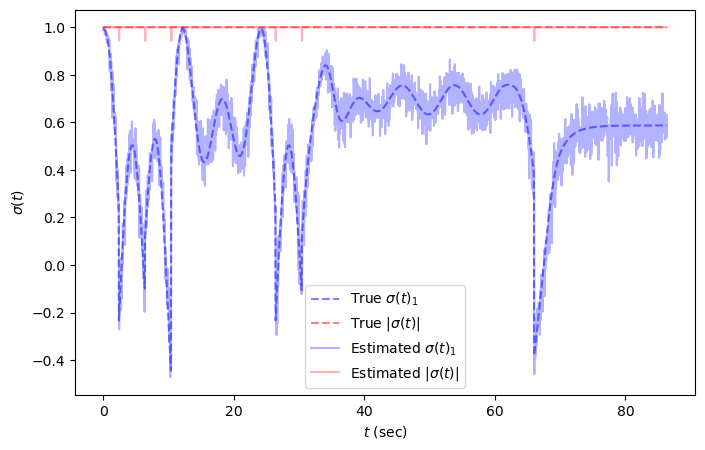

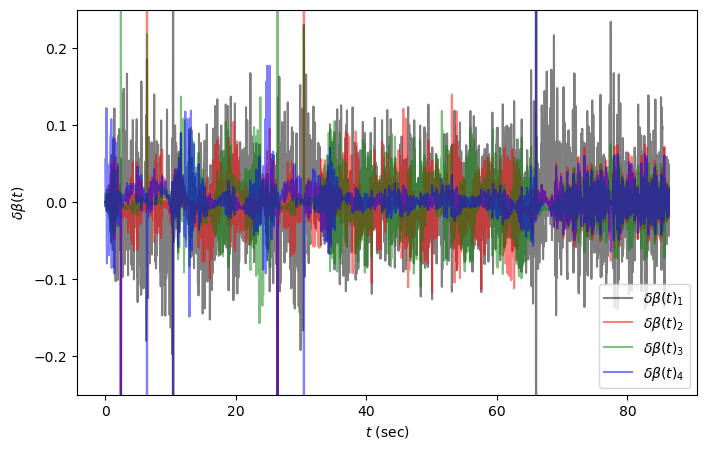

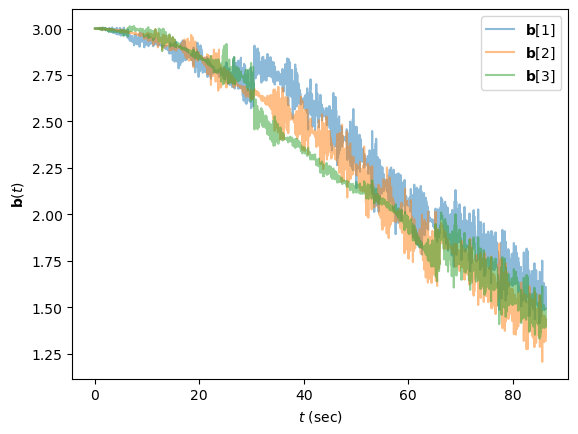

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0], alpha=0.5, color='blue', ls='--',
    label=r'True $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(b_true_data[:, :, 0], axis=1), alpha=0.5,
    color='red', label=r'True $|\sigma(t)|$', ls='--'
)
plt.plot(
    t_data[:], x_arr[:, 0, 0], alpha=0.3, color='blue', ls='-',
    label=r'Estimated $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(x_arr[:, :4, 0], axis=1), alpha=0.3,
    color='red', label=r'Estimated $|\sigma(t)|$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\sigma(t)$')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0] - x_arr[:, 0, 0], alpha=0.5,
    color='black', ls='-', label=r'$\delta\beta(t)_1$'
)
plt.plot(
    t_data[:], b_true_data[:, 1, 0] - x_arr[:, 1, 0], alpha=0.5,
    color='red', ls='-', label=r'$\delta\beta(t)_2$'
)
plt.plot(
    t_data[:], b_true_data[:, 2, 0] - x_arr[:, 2, 0], alpha=0.5,
    color='green', ls='-', label=r'$\delta\beta(t)_3$'
)
plt.plot(
    t_data[:], b_true_data[:, 3, 0] - x_arr[:, 3, 0], alpha=0.5,
    color='blue', ls='-', label=r'$\delta\beta(t)_4$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\delta\beta(t)$')
plt.legend()
plt.ylim(-0.25, 0.25)
plt.show()

plt.plot(t_data[:], x_arr[:, 4, 0] * 180. / jnp.pi, alpha=0.5, label=r'$\mathbf{b}[1]$')
plt.plot(t_data[:], x_arr[:, 5, 0] * 180. / jnp.pi, alpha=0.5, label=r'$\mathbf{b}[2]$')
plt.plot(t_data[:], x_arr[:, 6, 0] * 180. / jnp.pi, alpha=0.5, label=r'$\mathbf{b}[3]$')
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\mathbf{b}(t)$')
plt.legend()
plt.show()

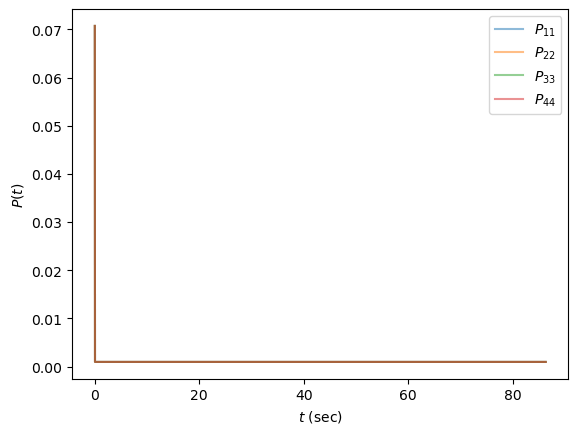

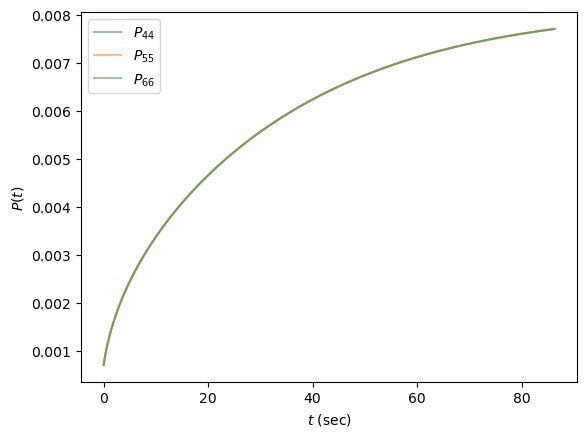

In [14]:
plt.plot(t_data[:], jnp.sqrt(P_arr[:, 0, 0]), alpha=0.5, label=r'$P_{11}$')
plt.plot(t_data[:], jnp.sqrt(P_arr[:, 1, 1]), alpha=0.5, label=r'$P_{22}$')
plt.plot(t_data[:], jnp.sqrt(P_arr[:, 2, 2]), alpha=0.5, label=r'$P_{33}$')
plt.plot(t_data[:], jnp.sqrt(P_arr[:, 3, 3]), alpha=0.5, label=r'$P_{44}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

plt.plot(t_data[:], jnp.sqrt(P_arr[:, 4, 4]), alpha=0.5, label=r'$P_{44}$')
plt.plot(t_data[:], jnp.sqrt(P_arr[:, 5, 5]), alpha=0.5, label=r'$P_{55}$')
plt.plot(t_data[:], jnp.sqrt(P_arr[:, 6, 6]), alpha=0.5, label=r'$P_{66}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

Will there be any improvment if we direclty enforce that $|\hat{\beta}| = 1$ for the entire state estimation run?
Let's define a new filter step function called `filter_step_norm()` to do just that.

In [91]:
def filter_step_norm(
    x_prior: jnp.ndarray,
    P_prior: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray,
    R_b: jnp.ndarray,
    Q_a: jnp.ndarray,
    Q_i: jnp.ndarray,
    H: jnp.ndarray,
    dt: float,
) -> Tuple[jnp.ndarray]:
    """ A single AEKF timestep with additional quaternion estimate
        renormalization steps.

    Args:
        x_prior (jnp.ndarray): 7x1 matrix, prior state vector estimate.
        P_prior (jnp.ndarray): 7x7 matrix, prior state covariance estimate.
        w_obs (jnp.ndarray): 3x1 matrix, observed attitude rate vector.
        b_obs (jnp.ndarray): 4x1 matrix, observed attitude, represented with
            quaternion b.
        R_b (jnp.ndarray): 4x4 matrix, quaternion measurement covariance.
        Q_a (jnp.ndarray): 7x7 matrix, additive process noise covariance.
        Q_i (jnp.ndarray): 7x7 matrix, internal process noise covariance.
        H (jnp.ndarray): 4x7 matrix, measurement model matrix.
        dt (float): Integration time interval.

    Returns:
        Tuple[jnp.ndarray]: 7x1 matrix, 7x7 matrix: updated state vector and
            state covariance estimates.
    """
    # Get linearized kinematics and noise matrices.
    F_prior = AEKF.tangent_f(x_prior, w_obs)
    G_prior = AEKF.tangent_g(x_prior)

    # Get posterior predictions for state vector and state covariance matrix.
    x_new = AEKF.pred_x(x_prior, w_obs, dt)
    P_new = AEKF.pred_P_ricatti(
        P_prior,
        F_prior,
        G_prior,
        Q_a,
        Q_i,
        dt
    )
    # Normalize.
    x_new = jnp.vstack(
        [x_new[:4, :] / jnp.linalg.norm(x_new[:4, :]),
         x_new[4:, :]]
    )

    # Get posterior error and Kalman gain.
    r = b_obs - H @ x_new
    K = calculate_K(P_new, R_b, H)

    # Update state vector and state covariance estimate with Kalman gain.
    x_post = x_new + K @ r
    # Normalize.
    x_post = jnp.vstack(
        [x_post[:4, :] / jnp.linalg.norm(x_post[:4, :]),
         x_post[4:, :]]
    )

    # Also, use Joseph form for covariance update.
    P_post = joseph_P(P_new, K, H, R_b)

    return x_post, P_post

# Update filter_step() to AEKF as as static method.
AEKF.filter_step_norm = staticmethod(filter_step_norm)

# Always reset!
# The bias should be around three degrees for all gyroscope axes.
bias = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial quaternion values will be the first observation's value.
b0 = b_obs_data[0].copy()
x = jnp.vstack([b0, bias])

# The initial state covariance will be the process covariance matrix multiplied
# by a constant > 1.
P = 5. * Q_a.copy()


@jit
def step_norm(
    x: jnp.ndarray,
    P: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray
) -> Tuple[jnp.ndarray]:
    """ AEKF filter step for given matrices R_w, R_b, and Q.
    """
    return AEKF.filter_step_norm(
        x, P, w_obs, b_obs,  # Variables.
        R_b, Q_a, Q_i, AEKF.H, dt  # Constants.
    )


# Loop through and append new estimates.
x_list_norm = []
P_list_norm = []
for i in range(n_steps):
    x_list_norm.append(x)
    P_list_norm.append(P)
    x, P = step_norm(
        x, P,
        w_obs_data[i], b_obs_data[i],
    )

# Convert to arrays.
x_arr_norm = jnp.array(x_list_norm)
P_arr_norm = jnp.array(P_list_norm)


TypeError: dot_general requires contracting dimensions to have the same shape, got (7,) and (6,).

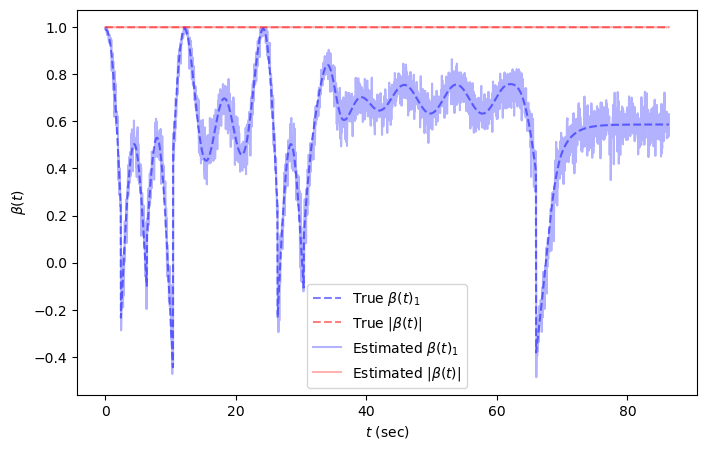

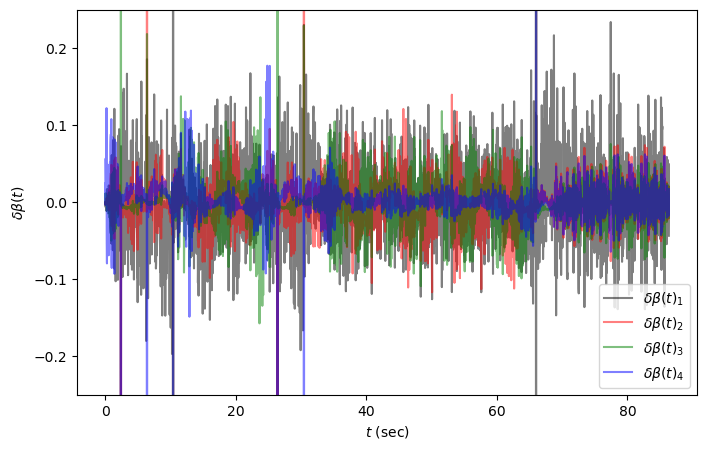

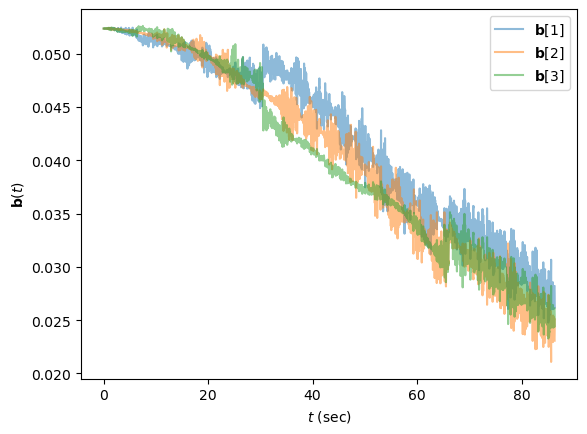

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0], alpha=0.5, color='blue', ls='--',
    label=r'True $\beta(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(b_true_data[:, :, 0], axis=1), alpha=0.5,
    color='red', label=r'True $|\beta(t)|$', ls='--'
)
plt.plot(
    t_data[:], x_arr_norm[:, 0, 0], alpha=0.3, color='blue', ls='-',
    label=r'Estimated $\beta(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(x_arr_norm[:, :4, 0], axis=1), alpha=0.3,
    color='red', label=r'Estimated $|\beta(t)|$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\beta(t)$')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0] - x_arr_norm[:, 0, 0], alpha=0.5,
    color='black', ls='-', label=r'$\delta\beta(t)_1$'
)
plt.plot(
    t_data[:], b_true_data[:, 1, 0] - x_arr_norm[:, 1, 0], alpha=0.5,
    color='red', ls='-', label=r'$\delta\beta(t)_2$'
)
plt.plot(
    t_data[:], b_true_data[:, 2, 0] - x_arr_norm[:, 2, 0], alpha=0.5,
    color='green', ls='-', label=r'$\delta\beta(t)_3$'
)
plt.plot(
    t_data[:], b_true_data[:, 3, 0] - x_arr_norm[:, 3, 0], alpha=0.5,
    color='blue', ls='-', label=r'$\delta\beta(t)_4$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\delta\beta(t)$')
plt.legend()
plt.ylim(-0.25, 0.25)
plt.show()

plt.plot(t_data[:], x_arr_norm[:, 4, 0], alpha=0.5, label=r'$\mathbf{b}[1]$')
plt.plot(t_data[:], x_arr_norm[:, 5, 0], alpha=0.5, label=r'$\mathbf{b}[2]$')
plt.plot(t_data[:], x_arr_norm[:, 6, 0], alpha=0.5, label=r'$\mathbf{b}[3]$')
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\mathbf{b}(t)$')
plt.legend()
plt.show()

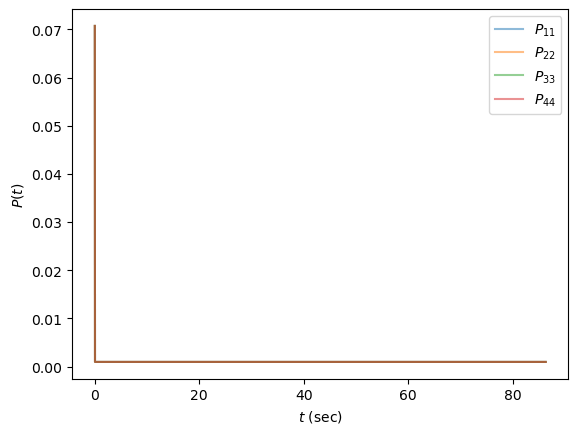

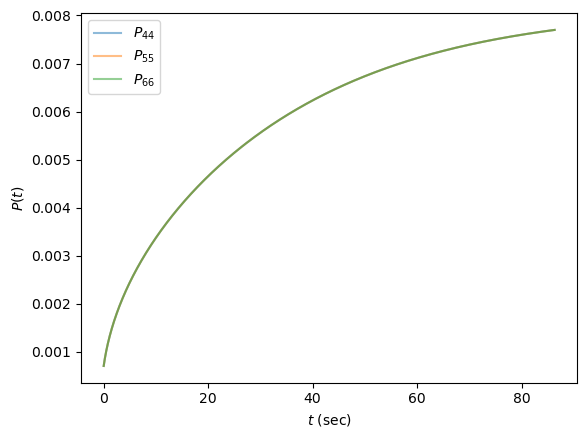

In [ ]:
plt.plot(t_data[:], jnp.sqrt(P_arr_norm[:, 0, 0]), alpha=0.5, label=r'$P_{11}$')
plt.plot(t_data[:], jnp.sqrt(P_arr_norm[:, 1, 1]), alpha=0.5, label=r'$P_{22}$')
plt.plot(t_data[:], jnp.sqrt(P_arr_norm[:, 2, 2]), alpha=0.5, label=r'$P_{33}$')
plt.plot(t_data[:], jnp.sqrt(P_arr_norm[:, 3, 3]), alpha=0.5, label=r'$P_{44}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

plt.plot(t_data[:], jnp.sqrt(P_arr_norm[:, 4, 4]), alpha=0.5, label=r'$P_{44}$')
plt.plot(t_data[:], jnp.sqrt(P_arr_norm[:, 5, 5]), alpha=0.5, label=r'$P_{55}$')
plt.plot(t_data[:], jnp.sqrt(P_arr_norm[:, 6, 6]), alpha=0.5, label=r'$P_{66}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

Interestingly enough, that doesn't seem to change anything other than correcting some sporadic $\hat{\beta}$ values that were not unit length.

### Potential AEKF Improvements

One issue we have yet to address which might be contributing the poor performance is that $[P]$, in its current formulation, is not consistent with the unit constraint $|\beta|=1$. 
One way we could get around this is by decreasing the state vector dimensnion $\mathbf{x}$ by one, opting to only track the quaternion vector components $\beta_1$, $\beta_2$, and $\beta_3$, which we'll denote as $\vec{\beta}$. 
From the unit constraint condition, we can always calculate $\beta_0 = 1 - \vec{\beta}\cdot\vec{\beta}$. 
Finally, the state covariance matrix for $\beta$ ($[P]_{\beta}$ for short) will now be a $3\times 3$ matrix instead of a $4\times 4$ one.

But what if $\beta_0$ becomes small? 
It's not unreasonable to expect numerical precision errors to compromise this approach. 
Any additive EKF algorithm that relies directly on the unit norm constraint for one of the four $\beta$ components will require switching between components to ensure that the component calculated from the unit norm condition does not become 'too small'. 
This algorithm will require switching between different $3\times 3$ state covariance matrices. 
See section 8.8 of [Carpenter & D'Souza](https://ntrs.nasa.gov/citations/20180003657) for more details on implementing this $\beta$ and $[P]_{\beta}$ switching.


Instead of making direct use of the norm constraint to reduce the state vector dimensionality, perhaps we instead we could better model the quaternion component of $[P]$ (denoted here as $[P]_{\beta}$)? 
As discussed in [Markley](https://ntrs.nasa.gov/citations/20040037784), if we are not respecting the unit constraint directly (which is obviously the case for the first AEKF algorithm implemented here, and less obviously for the second), then there are two components of uncertainty in the quaternion estimate $\hat{\beta}$:

$\hat{\beta} = \delta\beta(\mathbf{a}/2) \otimes \beta + \gamma\beta$,

where $\delta\beta(\mathbf{a}) = I_{\beta} + \frac{1}{2}[0, \mathbf{a}]^T$ is the error in direction and $\gamma$ is error in the norm. 
The 3-vector $\mathbf{a}$ contain angle uncertainties that are assumed small; $I_{\beta} =[1, 0, 0, 0]^T$ is the identity quaternion. 
Conceptually, this decomposition in quaternion estimate error corresponds to a rotational component $\delta\beta(\mathbf{a})$, which perserves the norm constraint of $\beta$ via the quaternion composition $\odot$ (assuming $|\mathbf{a}| \ll 1$), and an error component parallel to $\beta$ by some fractional error $\gamma$, *which does not* preserve the unit constraint of $\beta$.

If we define the $4\times 3$ matrix operator

$[\Xi] = \begin{bmatrix} -\vec{\beta}^T \\ \beta_0I_{3\times 3} + [\vec{\beta}]_{\times} \end{bmatrix}$,

where $[\vec{\beta}]_{\times}$ is the cross product operator of the quaternion's vector component, then the $4\times 4$ $[P]$ matrix can be factorized as:

$[P]_{\beta} = \begin{bmatrix}[\Xi] & \hat{\beta} \end{bmatrix} \begin{bmatrix}p_{\gamma} & \frac{1}{2}\mathbf{p}_{\gamma, \mathbf{a}}^T \\ \frac{1}{2}\mathbf{p}_{\gamma, \mathbf{a}} & \frac{1}{4}[P]_a\end{bmatrix} \begin{bmatrix}[\Xi] & \hat{\beta} \end{bmatrix}^T$.
 
$p_{\gamma}$ is the variance of $\gamma$, $[P]_a$ is the $3\times 3$ covariance matrix for $\mathbf{a}$, and $\mathbf{p}_{\gamma, \mathbf{a}}$ is the covariance (here presented as a $3\times 1$ vector) between $\gamma$ and $\mathbf{a}$. 
See [Markley](https://ntrs.nasa.gov/citations/20040037784) for derivation details.

Note that JAXitude provides a function to calculate this $[\Xi]$ operator and its sibling operator $[\Psi]$ in the `jaxitude.quaternions` submodule.


## Filter Two: Multiplicative Extended Kalman Filter

Unit quaternions form a group (specifically $\text{SO}(3)$), with the group operations being the quaternion compositions.
By definition, the group operation is closed, meaning any two group members composed by said operation yields another group member. 
Maybe we can use quaternion composition directly in our filtering algorithm, sidelining renormalization, switching, and covariance estimate factorization entirely?

Let's go back to the dynamics model provided above:

$\mathbf{x}_{k + 1} = \mathbf{x}_{k} + \dot{\mathbf{x}}_k\Delta t$.

Consider for now only the quaternion elements of $\mathbf{x}_k$:

$\beta_{k + 1} = \beta_{k} + \dot{\beta}_k\Delta t$,

where

$\dot{\beta} = \frac{1}{2}\beta \otimes \boldsymbol{\omega}^{\wedge} = \frac{1}{2}\beta \otimes (\bar{\boldsymbol{\omega}} - \mathbf{b} - \boldsymbol{\eta}_{\omega})^{\wedge}$,

and $\Delta t = t_{k + 1} - t_k$.
Let's generaize the the expression for $\beta_{k + 1}$ and define a state transition function $\phi_{\beta}(\beta_k, t_{k + 1}, t_k)$ which maps a prior state to the next state:

$\beta_{k + 1} = \phi_{\beta}(\beta_k, t_{k + 1}, t_k)$.

In the Euler's method or Runge-Kutta expression we used for the AEKF, the resulting $\phi_{\beta}$ function and its explicit use of addition, is clearly not length-preserving. 
We should want a formulation of $\phi_{\beta}$ that will preserve length, though. 
Again, unit quaternions are a representation of $\text{SO}(3)$, so why don't we try to define $\phi_{\beta}$ using its composition operation? 

### Numerical Integration Revision

The underlying dynamics will not change --- the physical system and our approximations are what they were for the AEKF algorithms. 
Instead, we want to reconsider how we numerically estimate state transitions for the quaternion component of $\mathbf{x}$. 

Euler's method (and similarly, Runge-Kutta methods), do not preserve the quaternion constraints because they follow the same basic additive approximation. 
Why don't we instead directly use the group operation to approximate state transitions?
To do this, we would need to solve $\dot{\beta} = \frac{1}{2}\beta \otimes \omega_4$ over a tiny time step $dt$.
It seems like an expenential should solve this differential equation, and indeed such an approach provides a reasonable approximate soluiton if we use the quaternion exponential map over the interval $\Delta t = t_{k + 1} - t_k$:

$\beta_{k + 1} = \beta_k \otimes (\boldsymbol{\omega} \Delta t)^{\wedge} = \beta_k \otimes \exp(\boldsymbol{\omega} \Delta t)$,

where

$\exp(\boldsymbol{\omega}\Delta t) = \begin{bmatrix} \cos\frac{\alpha}{2} \\ \frac{\boldsymbol{\omega}}{|\boldsymbol{\omega}|}\sin\frac{\alpha}{2} \end{bmatrix}$,

and

$\alpha = |\boldsymbol{\omega}| \Delta t$.

This is an example of a Lie group numerical integrator.
For completeness, the source code for `jaxitude.operations.integrator.quat_integrator()` is copied below for a reference implementation. 
Note that $|\boldsymbol{\omega}|$ is assume to be constant during time step $\Delta t$, an assumption that is a valid given our data set.

In [24]:
from jaxitude.quaternions import quat_expm, compose_quat, evolve_quat
from jaxitude.operations.integrator import autonomous_euler


def quat_integrator(
    b: jnp.ndarray,
    dt: float,
    w: jnp.ndarray,
    tol: float = 1e-6
) -> jnp.ndarray:
    """ First-order quaternion integrator based on Grouch-Grossman method,
        where w is constant during time step dt.

        If |w| < tol, then a linear approximation of Grouch-Grossman method is
        used to prevent numerical instability.

    Args:
        b (jnp.ndarray): 4x1 matrix, quaternion  before integration.
        dt (float): Integration time interval.
        w (jnp.ndarray): 3x1 matrix, angular rates during integration. Assumed
            to be constant during integration.
        to (float): Tolerance for switching to a linear approximation of the
            Grouch-Grossman method (aka switch to Euler's method). Defaults to
            1e-6.

    Returns:
        jnp.ndarray: 4x1 matrix, integrated quaternion.
    """

    return jnp.where(
        jnp.linalg.norm(w) < tol,
        autonomous_euler(
            evolve_quat,
            b, dt, w
        ),
        compose_quat(
            b,
            quat_expm(w * dt)
        )
    )

### Measurement Model Revision I

The biggest revision we will make for the MEKF algorithm is to completely change the error model for $\beta$.
Instead of a linear model as before (specifically, $\hat{\beta} = \beta + \delta\beta$), we will instead make use of quaternion composition so that our error model is guaranteed to produce another quaternion.

$\beta = \delta\beta(\mathbf{a}) \otimes \hat{\beta} \rightarrow \hat{\beta} = \beta \otimes \delta\beta(\mathbf{a})^{-1}$.

Here we assumed all body attitudes are given with respect to an intertial frame (we are in IRN).
$\mathbf{a}$ is a vector of three small principle rotations which parameterize the rotation error.
Note that we no longer need to parameterize any error in the norm.
Since elements of $\mathbf{a}$ are all small, we will approximate $\delta\beta(\mathbf{a})$ as

$\delta\beta(\mathbf{a}) = \mathbf{a}^{\wedge} \approx I_{\beta} + \frac{1}{2}\begin{bmatrix}0 \\ \mathbf{a}\end{bmatrix}$,

where we've explicitly linearized the exponential map operator $(.)^{\wedge}$.
For reference, also note that 

$\delta\beta(\mathbf{a})^{-1} = (-\mathbf{a})^{\wedge} \approx I_{\beta} + \frac{1}{2}\begin{bmatrix}0 \\ -\mathbf{a}\end{bmatrix}$.

Our linear approximation will approximately preserve the unit constraint on $\beta$ as long as $|\mathbf{a}| \ll 1$. 

We will refer to $\mathbf{a}$ as the local angle error, and it will be these parameters that we will progopate and update within our state vector $\mathbf{x}$.
This means $\mathbf{x}$ is now six-dimensional, not seven!
By working with the quaternion error parameterized by $\mathbf{a}$, we've removed a redundant quaternion parameter arising from the unit constraint.

### Measurement Model Revision II
We also need to wewrite the measurement model function $\mathbf{h}(\mathbf{x})$ to map $\mathbf{a}$ to $\mathbf{y} = \bar{beta}$ since attitude measurements are still given in quaternions.
To do so, first consider only the components of $\mathbf{h}$ that will act on $\mathbf{a}$, which we will denote here as $\mathbf{h}_{\beta}$
Since $\mathbf{a}$ is small, we can linearize $h_{\mathbf{x}}(\beta)$ by calculating its Jacobian with respect to $\beta$ and the Jacobian of $\beta$ with respect to $\alpha$. 
Exploiting the chain rule, we end up with.

$[H]_{\beta} = \frac{\partial \mathbf{h}_{\beta}}{\partial \beta} \frac{\partial \beta}{\partial \mathbf{a}} = I_{4\times 4} \frac{\partial \beta}{\partial \mathbf{a}}$.

Using the definition above and the handy $\Xi$ operator introduced before, we can provide a closed form matrix solution:

$[H] = I_{4\times 4} \frac{\partial \beta}{\partial \mathbf{a}} = \frac{\partial \beta}{\partial \mathbf{a}} = \frac{1}{2}\Xi(\beta) = \frac{1}{2} \begin{bmatrix} -\vec{\beta}^T \\ \beta_0I_{3\times 3} + [\vec{\beta}]_{\times} \end{bmatrix}$.

Thus, the $h_{\mathbf{x}}(\beta)$ measurement model will be

$h_{\beta}(\mathbf{x}) = \frac{1}{2} \begin{bmatrix} -\vec{\beta}^T \\ \beta_0I_{3\times 3} + [\vec{\beta}]_{\times} \end{bmatrix}(\mathbf{a} + \boldsymbol{\eta}_{\mathbf{a}})$,

where $\boldsymbol{\eta}_{\mathbf{a}} \sim \mathcal{N}(0, [Q]_{\mathbf{a}})$ is the process error for $\mathbf{a}$ with covariance $[Q]_{\mathbf{a}}$.
Finally, the full MEKF $[H]$ matrix will be

$[H] = [[H]_{\beta}, 0_{4\times3}]$.

Let's go ahead and implement this new measurement matrix $[H]$, making use of `jaxitude.quaternions.xi_op()` to calculate $[\Xi]$.

In [16]:
from jaxitude.quaternions import xi_op


def H(b: jnp.ndarray) -> jnp.ndarray:
    """ Generate MEKF measurement matrix from current quaternion estimate b.

    Args:
        b (jnp.ndarray): 4x1 matrix, current quaternion estimate.

    Returns:
        jnp.ndarray: 4x6 matrix, measurement matrix mapping state parameters
            a to measured quaternion. 
    """
    return jnp.hstack([0.5 * xi_op(b), jnp.zeros((4, 3))])

### Propagating $\mathbf{a}$

Since we are working directly with the local attitude error $\mathbf{a}$ in place of the global attitude $\beta$, we need a way to propagate $\mathbf{a}$ via some equation $\dot{\mathbf{a}}$. 
Using $\beta = \delta\beta(\mathbf{a}) \otimes \hat{\beta}$ and the product rule, we can plug in the definition of $\dot{\beta} = \frac{1}{2}\beta \otimes \boldsymbol{\omega}^{\wedge}$ to get

$\dot{\beta} = \delta\dot{\beta}(\mathbf{a}) \otimes \hat{\beta} + \delta{\beta}(\mathbf{a}) \otimes \dot{\hat{\beta}}$.

Solving for $\delta\dot{\beta}(\mathbf{a})$, we arrive at

$\delta\dot{\beta}(\mathbf{a}) = \frac{1}{2}\big[\boldsymbol{\omega}^{\wedge} \otimes \delta\beta - \delta\beta\otimes \hat{\boldsymbol{\omega}}^{\wedge}\big]$,

where $\boldsymbol{\omega} = \hat{\boldsymbol{\omega}} + \boldsymbol{\eta}_{\boldsymbol{\omega}}$ with error $\boldsymbol{\eta}_{\boldsymbol{\omega}}$. 
Plugging this definition for $\boldsymbol{\omega}$ and the definition for $\delta\beta(\mathbf{a})$ into $\delta\dot{\beta}(\mathbf{a})$, and doing somewhat tedious algebra whilst keeping only linear terms in $\mathbf{a}$ and $\boldsymbol{\eta}_{\boldsymbol{\omega}}$ will eventually yield

$\dot{\mathbf{a}} = \mathbf{a} \times \hat{\boldsymbol{\omega}} + \boldsymbol{\eta}_{\boldsymbol{\omega}}$.

To propagate the estimate $\hat{\mathbf{a}}$, we simply take the expectation of the above equation:

$\dot{\hat{\mathbf{a}}} = \hat{\mathbf{a}} \times \hat{\boldsymbol{\omega}} $.


### MEKF Dynamical System Model

Now that we have an expression for $\dot{\mathbf{a}}$, we can build the full MEKF dynamical model:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x} | \bar{\boldsymbol{\omega}} - \mathbf{b}) + \mathbf{g}(\mathbf{x}, \boldsymbol{\eta}) + \mathbf{e}_{\mathbf{x}}$

where

$\mathbf{f}(\mathbf{x} | \bar{\boldsymbol{\omega}} - \mathbf{b}) = \begin{bmatrix} \mathbf{a} \times (\bar{\boldsymbol{\omega}} - \mathbf{b}) \\ \mathbf{0} \end{bmatrix}$,

and

$\mathbf{g}(\mathbf{x}, \mathbf{\eta}) = \begin{bmatrix}-\mathbf{a} \times \boldsymbol{\eta}_{\boldsymbol{\omega}} \\ \mathbf{\boldsymbol{\eta}}_{\mathbf{b}} \end{bmatrix}$.

As before, $\mathbf{e}_{\mathbf{x}} \sim \mathcal{N}(0, [Q]^{(a)})$ is an additive process error arising from unmodeled physical processes with additive process noise covariance $[Q]^{(a)}$. 
Note that $[Q]^{(a)}$ is now a $6\times 6$ matrix.

Let's start building up the MEKF algorithm. 
We are also going to need to linearize $\dot{\mathbf{x}}$ to propagate $[P]$, so we will add that functionality that here as well.
Since the prediction steps for $\mathbf{x}$ and $[P]$ are unchanged, let's also code thme up.

In [74]:
from jax.scipy.linalg import block_diag
from jaxitude.base import colvec_cross

# This is a tuned approximation...  
sigmaQ_a = 1e-3
sigmaQ_bias_additional = 1e-4

q_gain = 10.
Q_a = q_gain * block_diag(
    jnp.eye(3) * sigmaQ_a**2.,
    jnp.eye(3) * sigmaQ_bias_additional**2.
)

# We also need to update Q_i to be a 6x6 matrix.
Q_i = block_diag(
    jnp.eye(3) * sigmaR_w**2,
    jnp.eye(3) * sigmaQ_bias**2
)

# We can calculate dt directly from the data right now.
dt = t_data[1] - t_data[0]



class MEKF:
    @staticmethod
    def f(
        x_est: jnp.ndarray,
        w: jnp.ndarray,
    ) -> jnp.ndarray:
        """ Dynamical system equations relating current state and measured rates
            w to dx/dt.

        Args:
            x_est (jnp.ndarray): 6x1 matrix, state vector estimate.
            w (jnp.ndarray): 3x1 matrix, measured rate vector.

        Returns:
            jnp.ndarray: 6x1 matrix, dx/dt.
        """
        return jnp.vstack(
            [
                colvec_cross(x_est[:3, :], w - x_est[3:, :]),
                jnp.zeros((3, 1))
            ]
        )

    @staticmethod
    def g(
        x_est: jnp.ndarray,
        eta: jnp.ndarray,
    ) -> jnp.ndarray:
        """ System noise equations calculated from state and noise vector.

        Args:
            x_est (jnp.ndarray): 6x1 matrix, state vector estimate.
            eta (jnp.ndarray): 6x1 matrix, noise vector.

        Returns:
            jnp.ndarray: 6x1 matrix, noise contribution to dx/dt.
        """
        return jnp.vstack(
            [
                -colvec_cross(x_est[:3, :], eta[:3, :]),
                eta[3:, :]
            ]
    )

    @staticmethod
    def tangent_f(
        x_est: jnp.ndarray,
        w_obs: jnp.ndarray
    ) -> jnp.ndarray:
        """ Gets the linearized kinematics equation matrix at x=x_ref:
            F = Jac(f(x, w=w_obs))(x_est).

        Args:
            x_est (jnp.ndarray): 6x1 matrix, state vector estimate to linearize
                at.
            w_obs (jnp.ndarray): 3x1 matrix, measured attitude rate vector.

        Returns:
            jnp.ndarray: 6x6 matrix, linearized kinematics system matrix F.
        """
        # Linearize f(x, w=w_obs) about x_est.
        return tangent(
            lambda x: MEKF.f(x, w_obs),
            6, 0, x_est
        )

    @staticmethod
    def tangent_g(
        x_est: jnp.ndarray,
    ) -> jnp.ndarray:
        """ Gets the linearized kinematics equation matrix at eta=0:
            G = Jac(g(x=x_est, eta))(eta=0).

        Args:
            x_est (jnp.ndarray): 6x1 matrix, state vector to linearize at.

        Returns:
            jnp.ndarray: 6x6 matrix, linearized noise system matrix G.
        """
        # Linearize g(x=x_est, eta) about eta=0.
        return tangent(
            lambda eta: MEKF.g(x_est, eta),
            6, 0, jnp.zeros((6, 1))
        )

    @staticmethod
    def pred_x(
        x_prior: jnp.ndarray,
        w_obs: jnp.ndarray,
        dt: float
    ) -> jnp.ndarray:
        """ Predicts new state vector x_post from x_prior and w_obs along time
            interval dt.

        Args:
            x_prior (jnp.ndarray): 6x1 matrix, prior state vector estimate.
            w_obs (jnp.ndarray): 6x1 matrix, current attitude rate vector
                measurement
            dt (float): time step to integrate.

        Returns:
            jnp.ndarray: 6x1 matrix, state vector transition output along time
                step dt.
        """
        return autonomous_rk4(
            MEKF.f,
            x_prior,
            dt,
            w_obs
        )

    @staticmethod
    def pred_P_ricatti(
        P_prior: jnp.ndarray,
        F_prior: jnp.ndarray,
        G_prior: jnp.ndarray,
        Q_a: jnp.ndarray,
        Q_i: jnp.ndarray,
        dt
    ) -> jnp.ndarray:
        """ Predict P_post from x_prior and covariance structures using Ricatti
            equation integrated with the RK4 method.

        Args:
            P_prior (jnp.ndarray): 6x6 matrix, prior P estimate.
            F_prior (jnp.ndarray): 6x6 matrix, linearized dynamics model
                evaluated at x_prior and w_obs.
            G_prior (jnp.ndarray): 6x6 matrix, linearized noise model
                evaluated at x_prior and w_obs.
            Q_a (jnp.ndarray): 6x6 matrix, additive process noise covariance.
            Q_i (jnp.ndarray): 6x6 matrix, internal process noise covariance.
            dt (float): Integration time interval.

        Returns:
            jnp.ndarray: 6x6 matrix, posterior P estimate from Ricatti equation
                integration.
        """
        return autonomous_rk4(
            evolve_P_ricatti,
            P_prior,
            dt,
            F_prior,
            G_prior,
            Q_a,
            Q_i
        )
    
# Also, add the H function to MEKF class as a static method for safe keeping.
MEKF.H = staticmethod(H)

### MEKF Workflow

As mentioned, the state vector $\mathbf{x}$ will directly track local angle errors $\mathbf{a}$ instead of the global attitude $\beta$. 
We still need to track the quaternion estimate $\hat{\beta}$ at each timestep independent of tracking $\hat{\mathbf{x}}$, though.
Overall, the MEKF algorithm workflow will be something like this:

- Propagate $\hat{\beta}_k$ estimate to get $\hat{\beta}_{k + 1}$ using $\dot{\beta}$.
- Propagate $\hat{\mathbf{x}}_k$ estimate to get $\hat{\mathbf{x}}_{k + 1}$ using $\dot{\mathbf{x}}$.
- Propagate $[\hat{P}]_k$ estimate to get $[\hat{\hat{P}}]_{k + 1}$ using $\dot{\mathbf{x}}$.
- Calculate the residual $\mathbf{r} = \mathbf{y}_{k + 1} - [H]\hat{\mathbf{x}}_{k + 1}$.
- Update $\mathbf{x}_{k + 1}^+ = \mathbf{x}_{k + 1} + [K]\mathbf{r}$.
- Update $[\hat{\hat{P}}]_{k + 1}^+$ using the Joseph form mentioned before.
- Update $\hat{\beta}_{k + 1}^+ = \hat{\beta}_{k + 1} \otimes \delta\beta(\mathbf{a}_{k + 1}^+)$.
- Reset $\mathbf{a}_{k + 1} = 0$.

The first step, and the last two steps, are what set MEKF apart from AEKF. 
At any given time step, we estimate the next global attitude estimate $\hat{\beta}_{k + 1}$ *and* a local attitude error estimate $\hat{\mathbf{a}}_{k + 1}$. 
We then update that local attitude error estimate $\hat{\mathbf{a}}_{k + 1}$ directly from our quaternion measurements $\bar{\beta}$ and the Kalman gain $[K]$. 
After that, the global estimate is updated using said local error estimate --- in effect, we are moving the posterior information from $\hat{\mathbf{a}}_{k + 1}^+$ to $\hat{\beta}_{k + 1}^+$. 
Having moved that information, we then finally reset $\hat{\mathbf{a}} = 0$ for the next filter step.
You can interpret the last step as being necessary given the definition of $\mathbf{a}$ as the local attitude error, which implies that at each filter step we are estimating the attitude error from that specific starting frame. 
As such, $\mathbf{a}$ should be zero at the beginning of each filter step to account for this implicit frame change.

Because we are tracking $\beta$ and $\mathbf{x}$, the filter step function will input and return an augmented vector $\mathbf{x}_{\text{aug}}$ instead of just $\mathbf{x}$, where

$\mathbf{x}_{\text{aug}} = \begin{bmatrix} \beta \\ \mathbf{x} \end{bmatrix}$.

Let's code up the $\beta$ propagation and MEKF filter steps, adding them to the class `MEKF`.

In [89]:
def pred_b(
    b_est: jnp.ndarray,
    w_obs: jnp.ndarray,
    dt: float
) -> jnp.ndarray:
    """ Predict the global attitude quaternion using quaternion integration.

    Args:
        b_est (jnp.ndarray): 4x1 matrix, prior quaternion estimate.
        w_obs (jnp.ndarray): 3x1 matrix, measured attitude rate.
        dt (float): Integration time interval.

    Returns:
        jnp.ndarray: 4x1 matrix, Propagated global attitude quaternion estimate.
    """
    # return autonomous_euler(
    #     evolve_quat,
    #     b_est,
    #     dt,
    #     w_obs
    # )
    return quat_integrator(
        b_est,
        dt,
        w_obs
    )


def update_b(
    b_new: jnp.ndarray,
    x_post: jnp.ndarray
) -> jnp.ndarray:
    """ Updates the propagated quaternion estimate with the local attitude
        error.

    Args:
        b_est (jnp.ndarray): 4x1 matrix, propagated quaternion estimate.
        b_est (jnp.ndarray): 6x1 matrix, updated state vector estimate.

    Returns:
        jnp.ndarray: 4x1 matrix, updated quaternion estimate.
    """
    b_temp = b_new + 0.5 * xi_op(b_new) @ x_post[:3, :]
    return b_temp / jnp.linalg.norm(b_temp)

# Add both functions to MEKF class.
MEKF.pred_b = staticmethod(pred_b)
MEKF.update_b = staticmethod(update_b)


def filter_step(
    x_aug_prior: jnp.ndarray,
    P_prior: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray,
    R_b: jnp.ndarray,
    Q_a: jnp.ndarray,
    Q_i: jnp.ndarray,
    H: jnp.ndarray,
    dt: float,
) -> Tuple[jnp.ndarray]:
    """ A single MEKF timestep.

    Args:
        x_prior (jnp.ndarray): 10x1 matrix, augmented prior state vector
            estimate.
        P_prior (jnp.ndarray): 6x6 matrix, prior state covariance estimate.
        w_obs (jnp.ndarray): 3x1 matrix, observed attitude rate vector.
        b_obs (jnp.ndarray): 4x1 matrix, observed attitude, represented with
            quaternion b.
        R_b (jnp.ndarray): 4x4 matrix, quaternion measurement covariance.
        Q_a (jnp.ndarray): 6x6 matrix, additive process noise covariance.
        Q_i (jnp.ndarray): 6x6 matrix, internal process noise covariance.
        H (jnp.ndarray): 4x6 matrix, measurement model matrix.
        dt (float): Integration time interval.

    Returns:
        Tuple[jnp.ndarray]: 10x1 matrix, 6x6 matrix: updated augmented state
            vector and state covariance estimates.
    """
    # Break up x_aug.
    b_prior = x_aug_prior[:4, :]
    x_prior = x_aug_prior[4:, :]

    # Reset local attitude error estimates to zero.
    x_prior = x_prior.at[:3, :].set(0.)

    # Get linearized kinematics and noise matrices.
    F_prior = MEKF.tangent_f(x_prior, w_obs)
    G_prior = MEKF.tangent_g(x_prior)

    # Get posterior predictions for global attitude quaternion, state vector,
    # and state covariance matrix.
    b_new = MEKF.pred_b(b_prior, w_obs, dt)
    x_new = MEKF.pred_x(x_prior, w_obs, dt)
    P_new = MEKF.pred_P_ricatti(
        P_prior,
        F_prior,
        G_prior,
        Q_a,
        Q_i,
        dt
    )

    # Get posterior error and Kalman gain.
    r = b_obs - H @ x_new
    K = calculate_K(P_new, R_b, H)
    print(K)

    # Update global attitude quaternion, state vector, and state covariance
    # estimates.
    bias_post = x_new[3:, :] + (K @ r)[3:, :]
    a_post = (jnp.eye(3) - (K @ H)[:3, :3]) @ x_new[:3, :] + (K @ (b_obs - b_new))[:3, :]
    x_post = jnp.vstack(
        [a_post, bias_post]
    )

    # Also, use Joseph form for covariance update.
    P_post = joseph_P(P_new, K, H, R_b)

    # Remember to update global attitude estimate.
    b_post = MEKF.update_b(b_new, x_post)

    # Build x_aug_post
    x_aug_post = jnp.vstack(
        [b_post, x_post]
    )

    return x_aug_post, P_post

# Add filter_step() to MEKF as as static method.
MEKF.filter_step = staticmethod(filter_step)

Like before, let's wrap this all up in a `step()` function to just in time compile.

In [90]:
from jax import jit

# Always reset!
# The bias should be around three degrees for all gyroscope axes.
bias = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial attitude error value will a zero vector.
a0 = jnp.zeros((3, 1))
x = jnp.vstack([a0, bias])

# Build the augmented state vector with initial global quaternion estimate.
b0 = b_obs_data[0].copy()
x_aug = jnp.vstack([b0, x])

# The initial state covariance will be the additive process covariance matrix 
# multiplied by a constant.
P = 5. * Q_a.copy()

# @jit
def step_MEKF(
    x_aug: jnp.ndarray,
    P: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray
) -> Tuple[jnp.ndarray]:
    """ MEKF filter step for given matrices R_w, R_b, and Q.
    """
    return MEKF.filter_step(
        x_aug, P, w_obs, b_obs,  # Variables.
        R_b, Q_a, Q_i, MEKF.H(b_obs), dt  # Constants.
    )


# Loop through and append new estimates.
x_aug_list = []
P_list = []
for i in range(n_steps):
    x_aug_list.append(x_aug)
    P_list.append(P)
    x_aug, P = step_MEKF(
        x_aug, P,
        w_obs_data[i], b_obs_data[i],
    )
    break

# Convert to arrays.
x_aug_arr = jnp.array(x_aug_list)
P_arr = jnp.array(P_list)

[[ 1.24537784  0.29618804  1.34526618 -0.95164473]
 [ 0.32424039 -1.0859339   0.22821362  1.48771046]
 [-1.61120641  1.35465815 -0.8980098   0.21847125]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


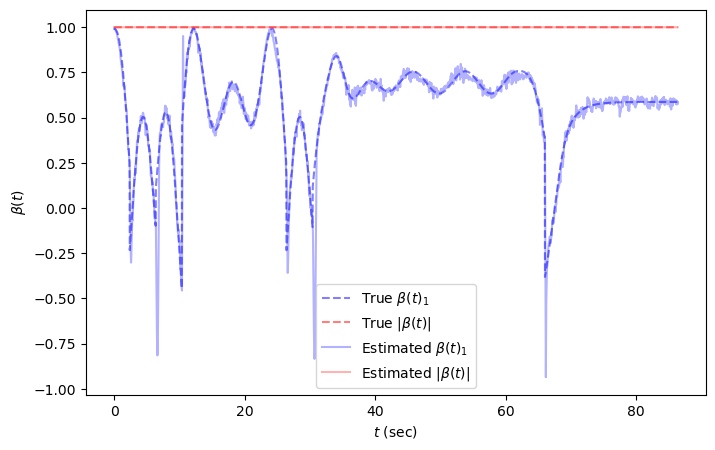

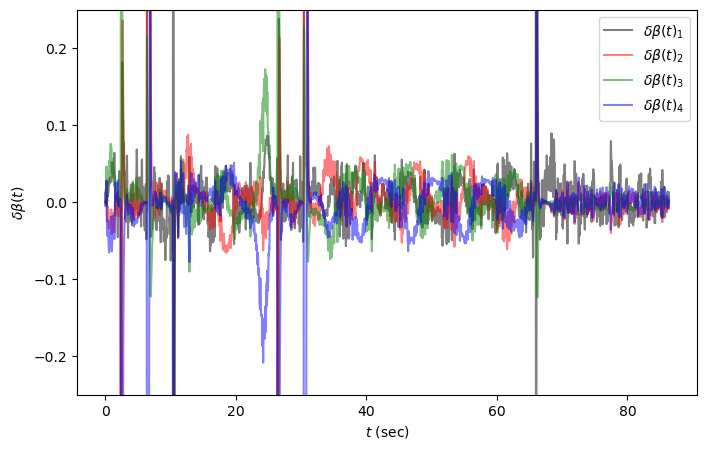

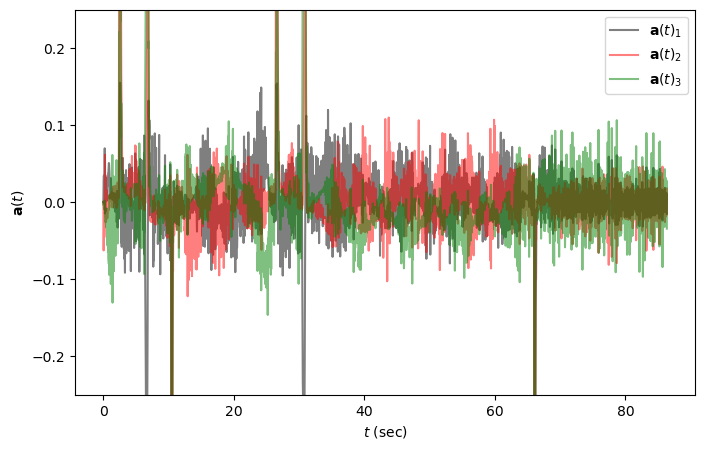

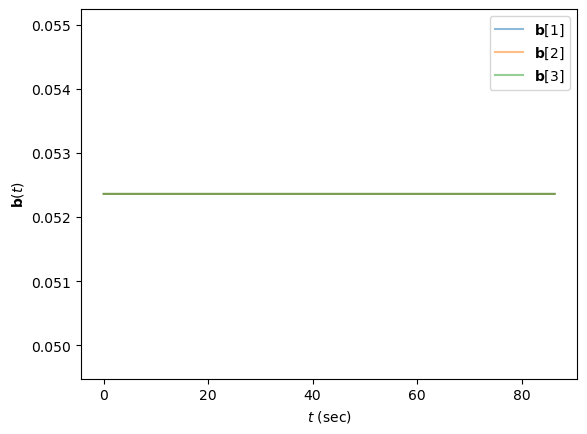

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0], alpha=0.5, color='blue', ls='--',
    label=r'True $\beta(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(b_true_data[:, :, 0], axis=1), alpha=0.5,
    color='red', label=r'True $|\beta(t)|$', ls='--'
)
plt.plot(
    t_data[:], x_aug_arr[:, 0, 0], alpha=0.3, color='blue', ls='-',
    label=r'Estimated $\beta(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(x_aug_arr[:, :4, 0], axis=1), alpha=0.3,
    color='red', label=r'Estimated $|\beta(t)|$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\beta(t)$')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0] - x_aug_arr[:, 0, 0], alpha=0.5,
    color='black', ls='-', label=r'$\delta\beta(t)_1$'
)
plt.plot(
    t_data[:], b_true_data[:, 1, 0] - x_aug_arr[:, 1, 0], alpha=0.5,
    color='red', ls='-', label=r'$\delta\beta(t)_2$'
)
plt.plot(
    t_data[:], b_true_data[:, 2, 0] - x_aug_arr[:, 2, 0], alpha=0.5,
    color='green', ls='-', label=r'$\delta\beta(t)_3$'
)
plt.plot(
    t_data[:], b_true_data[:, 3, 0] - x_aug_arr[:, 3, 0], alpha=0.5,
    color='blue', ls='-', label=r'$\delta\beta(t)_4$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\delta\beta(t)$')
plt.legend()
plt.ylim(-0.25, 0.25)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], x_aug_arr[:, 4, 0], alpha=0.5,
    color='black', ls='-', label=r'$\mathbf{a}(t)_1$'
)
plt.plot(
    t_data[:], x_aug_arr[:, 5, 0], alpha=0.5,
    color='red', ls='-', label=r'$\mathbf{a}(t)_2$'
)
plt.plot(
    t_data[:], x_aug_arr[:, 6, 0], alpha=0.5,
    color='green', ls='-', label=r'$\mathbf{a}(t)_3$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\mathbf{a}(t)$')
plt.legend()
plt.ylim(-0.25, 0.25)
plt.show()

plt.plot(t_data[:], x_aug_arr[:, 7, 0], alpha=0.5, label=r'$\mathbf{b}[1]$')
plt.plot(t_data[:], x_aug_arr[:, 8, 0], alpha=0.5, label=r'$\mathbf{b}[2]$')
plt.plot(t_data[:], x_aug_arr[:, 9, 0], alpha=0.5, label=r'$\mathbf{b}[3]$')
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\mathbf{b}(t)$')
plt.legend()
plt.show()

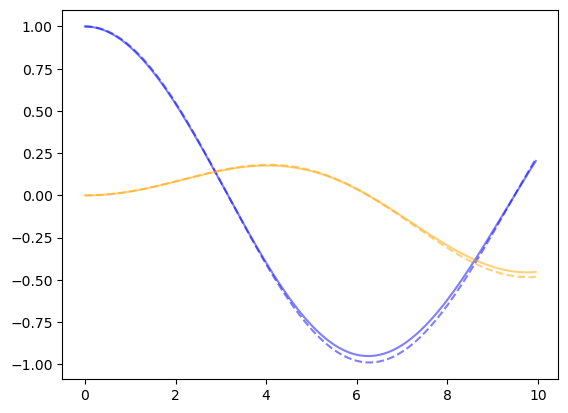

In [81]:
def quat_integrator(
    b: jnp.ndarray,
    dt: float,
    w: jnp.ndarray,
    tol: float = 1e-6
) -> jnp.ndarray:
    """ First-order quaternion integrator based on Grouch-Grossman method,
        where w is constant during time step dt.

        If |w| < tol, then a linear approximation of Grouch-Grossman method is
        used to prevent numerical instability.

    Args:
        b (jnp.ndarray): 4x1 matrix, quaternion  before integration.
        dt (float): Integration time interval.
        w (jnp.ndarray): 3x1 matrix, angular rates during integration. Assumed
            to be constant during integration.
        to (float): Tolerance for switching to a linear approximation of the
            Grouch-Grossman method (aka switch to Euler's method). Defaults to
            1e-6.

    Returns:
        jnp.ndarray: 4x1 matrix, integrated quaternion.
    """

    return jnp.where(
        jnp.linalg.norm(w) < tol,
        autonomous_euler(
            evolve_quat,
            b, dt, w
        ),
        compose_quat(
            b,
            quat_expm(w * dt)
        )
    )

w_func = lambda t: jnp.array(
    [[jnp.sin(0.1 * t)],
     [jnp.cos(0.1 * t)],
     [0.]]
)

b1 = jnp.array(
    [[1.],
     [0.],
     [0.],
     [0.]]
)
b2 = b1.copy()

b1_list = []
b2_list = []
dt = 0.05
t_arr = jnp.arange(0., 10., dt)

integrator1 = lambda b, w: autonomous_euler(
        evolve_quat,
        b,
        dt,
        w
    )

integrator2 = lambda b, w: quat_integrator(
        b,
        dt,
        w
    )

for t in t_arr:
    w = w_func(t)
    b1_list.append(b1)
    b2_list.append(b2)
    b1 = integrator1(b1, w)
    b2 = integrator2(b2, w)



b1_arr = jnp.array(b1_list)
b2_arr = jnp.array(b2_list)
plt.plot(t_arr, b1_arr[:, 0, :], color='blue', ls='--', alpha=0.5)
plt.plot(t_arr, b2_arr[:, 0, :], color='blue', ls='-', alpha=0.5)

plt.plot(t_arr, b1_arr[:, 1, :], color='orange', ls='--', alpha=0.5)
plt.plot(t_arr, b2_arr[:, 1, :], color='orange', ls='-', alpha=0.5)